# Training Classifier
1. Load and normalize the CIFAR10 training and test datasets using `torchvision`
2. Define a CNN
3. Define a lost function.
4. Train the network on the training data.
5. Test the network on the test data.

## Load and Normalize CIFAR10

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root = '../data',
    train = True,
    download= True,
    transform= transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


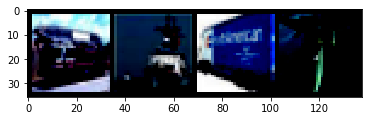

     truck       ship      truck      plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size)))

# Define a CNN

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x =self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define Loss function and optimizer

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network

In [12]:
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.842
[1,  6000] loss: 1.681
[1,  8000] loss: 1.576
[1, 10000] loss: 1.507
[1, 12000] loss: 1.458
[2,  2000] loss: 1.387
[2,  4000] loss: 1.375
[2,  6000] loss: 1.344
[2,  8000] loss: 1.326
[2, 10000] loss: 1.295
[2, 12000] loss: 1.255
Finished Training


# Save model

In [14]:
PATH = '../cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test the network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


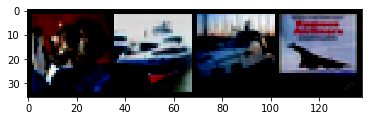

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [26]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 47.4 %
Accuracy for class car   is: 67.9 %
Accuracy for class bird  is: 43.3 %
Accuracy for class cat   is: 44.5 %
Accuracy for class deer  is: 30.7 %
Accuracy for class dog   is: 37.3 %
Accuracy for class frog  is: 84.7 %
Accuracy for class horse is: 56.0 %
Accuracy for class ship  is: 83.3 %
Accuracy for class truck is: 58.1 %
